In [7]:
import itertools
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_validate

# Classification

In [4]:
train_set = pd.read_csv("./SpamData/spam_train.csv")
test_set = pd.read_csv("./SpamData/spam_test.csv")

In [5]:
X_train = np.array(train_set[list(train_set.columns[1:-1])])
y_train = np.array(train_set["class"])
X_test = np.array(test_set[list(test_set.columns[1:-1])])
y_test = np.array(test_set["class"])

## KNN

In [13]:
val_accs_knn = []
train_accs_knn = []
k_range = np.arange(1,21)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, X_train, y_train, cv=4, return_train_score=True)
    
    train_accs_knn.append(np.round(100*np.mean(cv_results["train_score"]),2))
    val_accs_knn.append(np.round(100*np.mean(cv_results["test_score"]),2))

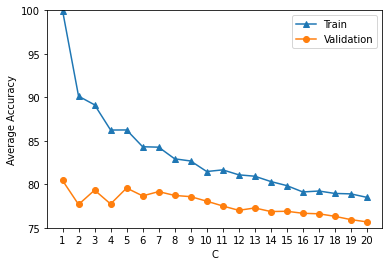

In [19]:
plt.plot(k_range,train_accs_knn, marker="^",label="Train")
plt.plot(k_range,val_accs_knn, marker="o", label="Validation")
_ = plt.xticks(k_range)
plt.xlabel("C")
plt.ylabel("Average Accuracy")
plt.ylim(bottom=75, top=100)
plt.legend()

In [27]:
optimal_k = 5
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

TestAccuracy = knn.score(X_test, y_test)
TestAccuracy

0.788010425716768

In [28]:
# Indices of misclassified samples
y_pred = knn.predict(X_test)
misclassified_indices = np.where((y_pred!=y_test))[0]

In [29]:
#Identify k nearest neighbors from the training set for each misclassified test sample
k = 3
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_train)
distances, indices = nn.kneighbors(X_test[misclassified_indices])

In [30]:
columns = ["Misclassified Test idx", "True Class", "Pred Class"]
for i in range(k):
    columns+= ["Neigbor#{}_idx".format(i+1), "Neigbor#{}_True Class".format(i+1), "Neigbor#{}_Distance".format(i+1)]

df = pd.DataFrame(columns = columns)

df["Misclassified Test idx"] = misclassified_indices
df["True Class"] =  y_test[misclassified_indices]
df["Pred Class"] = y_pred[misclassified_indices]
for i in range(k):
    df["Neigbor#{}_idx".format(i+1)] = indices[:,i]
    df["Neigbor#{}_True Class".format(i+1)] = y_train[indices[:,i]]
    df["Neigbor#{}_Distance".format(i+1)] = np.around(distances[:,i], decimals=2)

In [113]:
df

,Misclassified Test idx,True Class,Pred Class,Neigbor#1_idx,Neigbor#1_True Class,Neigbor#1_Distance,Neigbor#2_idx,Neigbor#2_True Class,Neigbor#2_Distance,Neigbor#3_idx,Neigbor#3_True Class,Neigbor#3_Distance
0,0,0,1,2757,1,2.81,922,1,3.38,1155,1,3.44
1,2,1,0,2084,0,2.62,86,1,2.85,1093,1,2.85
2,8,1,0,2378,1,2.25,811,0,3.15,2824,0,3.17
3,9,0,1,909,1,5.23,2690,0,5.53,3301,1,6.42
4,11,1,0,3221,1,0.00,1162,0,4.97,3139,0,5.28
...,...,...,...,...,...,...,...,...,...,...,...,...
239,1129,1,0,1207,1,3.02,3174,0,4.64,2744,0,5.86
240,1134,1,0,499,0,9.12,3078,1,10.20,1056,0,12.19
241,1137,1,0,1588,1,2.00,1854,1,5.21,360,0,7.20
242,1139,0,1,1735,0,3.16,2483,1,6.24,865,1,6.42


In [123]:
idx = 243 #between 0 and 243
print("Test sample {} is misclassified.".format(misclassified_indices[idx]))
print("True class: {}".format(y_test[misclassified_indices][idx]))
print("Predicted class: {}".format(y_pred[misclassified_indices][idx]))
for i in range(k):
    print("Neighbor#{}: Train index {} ; True Class {} ; Distance {:.2f}".format(i+1, indices[idx,i], y_train[indices[idx,i]], distances[idx, i]))

Test sample 1147 is misclassified.
True class: 1
Predicted class: 0
Neighbor#1: Train index 331 ; True Class 0 ; Distance 4.91
Neighbor#2: Train index 3047 ; True Class 1 ; Distance 4.99
Neighbor#3: Train index 153 ; True Class 0 ; Distance 5.14


## Logistic Regression

In [50]:
val_accs_LR = []
train_accs_LR = []
c_vals = [0.1,1.0,2.0,3.0,5.0, 10]
for i in c_vals:
    LR = LogisticRegression(random_state=0, C=i, solver = "liblinear")
    cv_results = cross_validate(LR, X_train, y_train, cv=4, return_train_score=True)

    train_accs_LR.append(np.round(100*np.mean(cv_results["train_score"]),2))
    val_accs_LR.append(np.round(100*np.mean(cv_results["test_score"]),2))

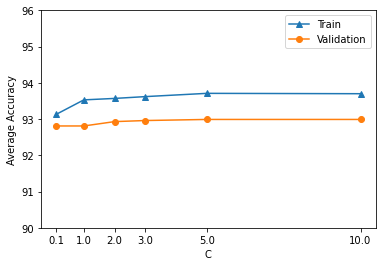

In [55]:
plt.plot(c_vals,train_accs_LR, marker="^",label="Train")
plt.plot(c_vals,val_accs_LR, marker="o", label="Validation")
_ = plt.xticks(c_vals)
plt.xlabel("C")
plt.ylabel("Average Accuracy")
plt.ylim(bottom=90, top=96)
plt.legend()

### RUN FROM HERE

In [69]:
optimal_C = 1.0
LR = LogisticRegression(random_state=0, C=i, solver = "liblinear")
LR.fit(X_train, y_train)

TestAccuracy = LR.score(X_test, y_test)
TestAccuracy


0.9226759339704604

In [140]:
# Indices of misclassified samples
y_pred = LR.predict(X_test)
misclassified_indices = np.where((y_pred!=y_test))[0]

In [141]:
#Identify k nearest neighbors from the training set for each misclassified test sample
k = 3
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_train)
distances, indices = nn.kneighbors(X_test[misclassified_indices])

In [142]:
columns = ["Misclassified Test idx", "True Class", "Pred Class"]
for i in range(k):
    columns+= ["Neigbor#{}_idx".format(i+1), "Neigbor#{}_True Class".format(i+1), "Neigbor#{}_Distance".format(i+1)]

df = pd.DataFrame(columns = columns)

df["Misclassified Test idx"] = misclassified_indices
df["True Class"] =  y_test[misclassified_indices]
df["Pred Class"] = y_pred[misclassified_indices]
for i in range(k):
    df["Neigbor#{}_idx".format(i+1)] = indices[:,i]
    df["Neigbor#{}_True Class".format(i+1)] = y_train[indices[:,i]]
    df["Neigbor#{}_Distance".format(i+1)] = np.around(distances[:,i], decimals=2)

In [143]:
df

,Misclassified Test idx,True Class,Pred Class,Neigbor#1_idx,Neigbor#1_True Class,Neigbor#1_Distance,Neigbor#2_idx,Neigbor#2_True Class,Neigbor#2_Distance,Neigbor#3_idx,Neigbor#3_True Class,Neigbor#3_Distance
0,22,1,0,3181,1,4.17,3440,0,4.40,1792,0,4.41
1,26,1,0,3415,0,4.56,3054,1,5.01,2961,0,11.85
2,32,1,0,935,0,2.04,3177,0,2.09,2100,1,2.39
3,52,1,0,2233,1,0.55,2747,0,2.46,3417,1,3.30
4,53,1,0,2147,0,4.96,1391,0,7.80,1990,0,8.55
...,...,...,...,...,...,...,...,...,...,...,...,...
83,1120,0,1,3120,0,5.42,1034,1,5.90,1097,0,6.06
84,1125,1,0,2598,1,1.01,12,1,5.19,2918,0,5.42
85,1131,1,0,1580,0,3.00,3131,1,5.23,3419,1,5.29
86,1141,1,0,62,1,0.00,1734,1,0.00,631,1,0.00


In [144]:
idx = 1 #between 0 and 87
print("Test sample {} is misclassified.".format(misclassified_indices[idx]))
print("True class: {}".format(y_test[misclassified_indices][idx]))
print("Predicted class: {}".format(y_pred[misclassified_indices][idx]))
for i in range(k):
    print("Neighbor#{}: Train index {} ; True Class {} ; Distance {:.2f}".format(i+1, indices[idx,i], y_train[indices[idx,i]], distances[idx, i]))

Test sample 26 is misclassified.
True class: 1
Predicted class: 0
Neighbor#1: Train index 3415 ; True Class 0 ; Distance 4.56
Neighbor#2: Train index 3054 ; True Class 1 ; Distance 5.01
Neighbor#3: Train index 2961 ; True Class 0 ; Distance 11.85


## Linear Support Vector Machines Classifier

In [74]:
val_accs_SVM = []
train_accs_SVM = []
c_vals = [0.1,1.0,5.0, 10.0, 15.0, 20.0]
for i in c_vals:
    SVM = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, C=i)) 
    cv_results = cross_validate(SVM, X_train, y_train, cv=4, return_train_score=True)

    train_accs_SVM.append(np.round(100*np.mean(cv_results["train_score"]),2))
    val_accs_SVM.append(np.round(100*np.mean(cv_results["test_score"]),2))

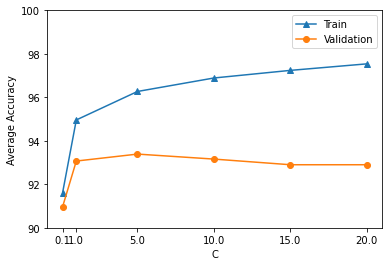

In [75]:
plt.plot(c_vals,train_accs_SVM, marker="^",label="Train")
plt.plot(c_vals,val_accs_SVM, marker="o", label="Validation")
_ = plt.xticks(c_vals)
plt.xlabel("C")
plt.ylabel("Average Accuracy")
plt.ylim(bottom=90, top=100)
plt.legend()

In [76]:
optimal_C = 5.0
SVM = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, C=i))
SVM.fit(X_train, y_train)
TestAccuracy = SVM.score(X_test, y_test)
TestAccuracy

0.9235447437011295

In [64]:
# Indices of misclassified samples
y_pred = clf.predict(X_test)
misclassified_indices = np.where((y_pred!=y_test))[0]

In [65]:
#Identify k nearest neighbors from the training set for each misclassified test sample
k = 3
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_train)
distances, indices = nn.kneighbors(X_test[misclassified_indices])

In [66]:
columns = ["Misclassified Test idx", "True Class", "Pred Class"]
for i in range(k):
    columns+= ["Neigbor#{}_idx".format(i+1), "Neigbor#{}_True Class".format(i+1), "Neigbor#{}_Distance".format(i+1)]

df = pd.DataFrame(columns = columns)

df["Misclassified Test idx"] = misclassified_indices
df["True Class"] =  y_test[misclassified_indices]
df["Pred Class"] = y_pred[misclassified_indices]
for i in range(k):
    df["Neigbor#{}_idx".format(i+1)] = indices[:,i]
    df["Neigbor#{}_True Class".format(i+1)] = y_train[indices[:,i]]
    df["Neigbor#{}_Distance".format(i+1)] = np.around(distances[:,i], decimals=2)

In [67]:
df

,Misclassified Test idx,True Class,Pred Class,Neigbor#1_idx,Neigbor#1_True Class,Neigbor#1_Distance,Neigbor#2_idx,Neigbor#2_True Class,Neigbor#2_Distance,Neigbor#3_idx,Neigbor#3_True Class,Neigbor#3_Distance
0,22,1,0,3181,1,4.17,3440,0,4.40,1792,0,4.41
1,26,1,0,3415,0,4.56,3054,1,5.01,2961,0,11.85
2,32,1,0,935,0,2.04,3177,0,2.09,2100,1,2.39
3,51,1,0,579,1,2.33,1001,0,2.78,491,1,2.82
4,52,1,0,2233,1,0.55,2747,0,2.46,3417,1,3.30
...,...,...,...,...,...,...,...,...,...,...,...,...
84,1120,0,1,3120,0,5.42,1034,1,5.90,1097,0,6.06
85,1125,1,0,2598,1,1.01,12,1,5.19,2918,0,5.42
86,1131,1,0,1580,0,3.00,3131,1,5.23,3419,1,5.29
87,1141,1,0,62,1,0.00,1734,1,0.00,631,1,0.00


In [138]:
idx = 3 #between 0 and 89
print("Test sample {} is misclassified.".format(misclassified_indices[idx]))
print("True class: {}".format(y_test[misclassified_indices][idx]))
print("Predicted class: {}".format(y_pred[misclassified_indices][idx]))
for i in range(k):
    print("Neighbor#{}: Train index {} ; True Class {} ; Distance {:.2f}".format(i+1, indices[idx,i], y_train[indices[idx,i]], distances[idx, i]))

Test sample 26 is misclassified.
True class: 1
Predicted class: 0
Neighbor#1: Train index 3415 ; True Class 0 ; Distance 4.56
Neighbor#2: Train index 3054 ; True Class 1 ; Distance 5.01
Neighbor#3: Train index 2961 ; True Class 0 ; Distance 11.85


In [68]:
print("Predicted probabilities KNN:\n{}".format(knn.predict_proba(X_test[:6])))


Predicted probabilities KNN:
[[0.2 0.8]
 [1.  0. ]
 [0.6 0.4]
 [1.  0. ]
 [0.8 0.2]
 [0.  1. ]]


In [71]:
print("Predicted probabilities LR:\n{}".format(LR.predict_proba(X_test[:6])))

Predicted probabilities LR:
[[8.24594983e-01 1.75405017e-01]
 [8.42203265e-01 1.57796735e-01]
 [1.10217092e-02 9.88978291e-01]
 [9.97777748e-01 2.22225234e-03]
 [9.99752258e-01 2.47742025e-04]
 [1.53034488e-01 8.46965512e-01]]


In [93]:
print("Predicted probabilities SVM:\n{}".format(SVM.predict_proba(X_test[:6] )))

Predicted probabilities SVM:
[[9.89171397e-01 1.08286027e-02]
 [9.87285509e-01 1.27144909e-02]
 [8.64049011e-07 9.99999136e-01]
 [8.14380000e-01 1.85620000e-01]
 [9.97469469e-01 2.53053072e-03]
 [8.23155769e-02 9.17684423e-01]]


In [101]:
SVM_Pred = SVM.predict_proba(X_test)
KNN_Pred = knn.predict_proba(X_test)
LR_Pred = LR.predict_proba(X_test)
 

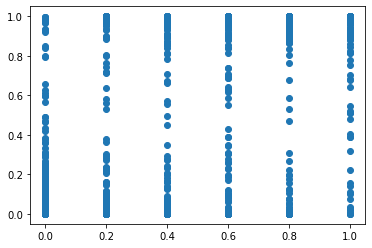

In [100]:
plt.scatter(KNN_Pred[:,1],SVM_Pred[:,1]   )
plt.show()

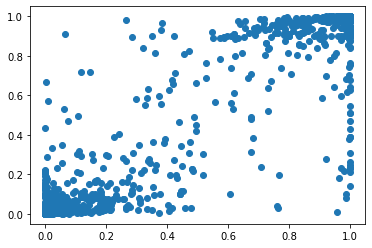

In [102]:
plt.scatter(LR_Pred[:,1],SVM_Pred[:,1]   )
plt.show()
